## Overview of MIRA workflow
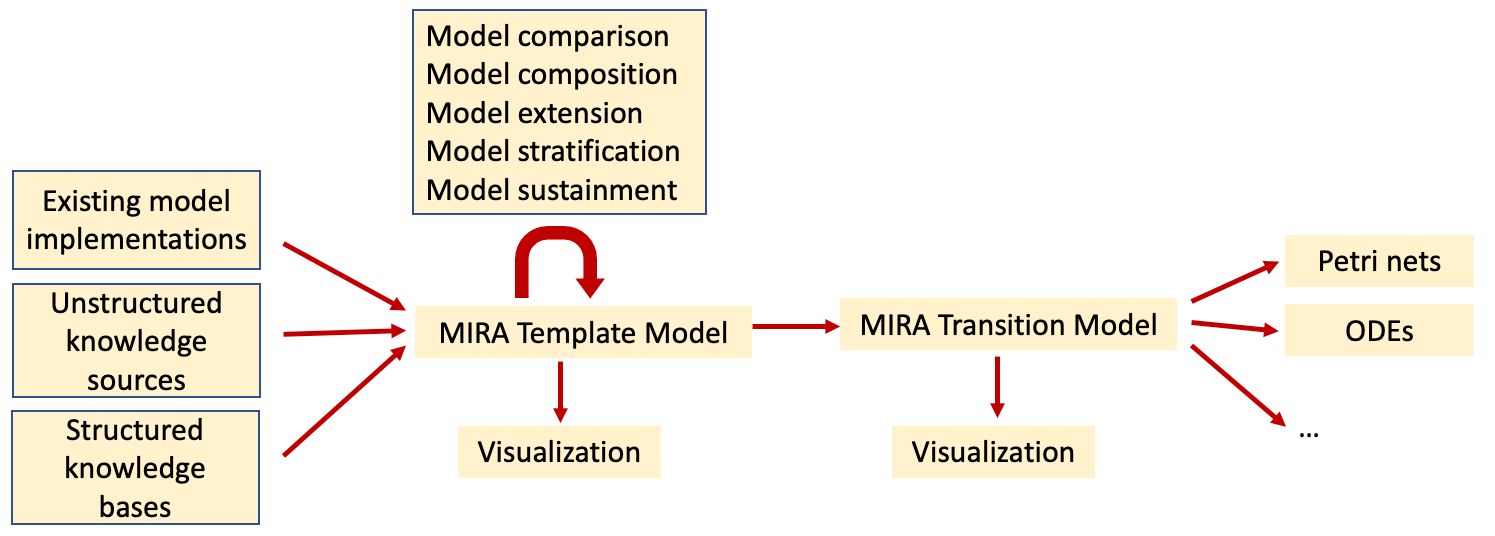

## Ingesting structured models with MIRA
The BioModels database contains 26 published COVID-19 models. Each of these models is available in a structured format: SBML. MIRA implements a client to BioModels and a processor to reverse-engineer SBML models into MIRA templates.

In [1]:
%%html
<iframe src="https://www.ebi.ac.uk/biomodels/search?query=submitter_keywords:COVID-19&domain=biomodels" width="950" height="600"></iframe>

Input formats supported
- Models can be directly represented via template objects: https://miramodel.readthedocs.io/en/latest/metamodel.html
- Bilayer: https://miramodel.readthedocs.io/en/latest/sources.html#module-mira.sources.bilayer
- SBML: https://miramodel.readthedocs.io/en/latest/sources.html#module-mira.sources.sbml

## Representing models using ontology-grounded meta-model templates
Let's get a specific model from BioModels as an example. This is a simple SIR model which is reverse-engineered into a ControlledConversion and NaturalConversion template.

In [2]:
from mira.sources.biomodels import get_template_model
# from mira.sources.sbml import template_model_from_sbml_file_path

# Uncomment this to allow local fallback
# def local_get_template_model(model_id): 
#    return template_model_from_sbml_file_path(
#        f'~/.data/mira/biomodels/{model_id}/{model_id}.xml').template_model
# get_template_model = local_get_template_model

template_model = get_template_model('BIOMD0000000956')

Each template refers to a set of Concepts as arguments (the role of these Concepts is also well defined semantically) and. These Concepts also carry identifiers and context, grounded in namespaces and identifiers consistent with the MIRA DKG.

In [3]:
for template in template_model.templates:
    print(template.type)
    for key, value in template.get_concepts_by_role().items():
        print('  %s - Concept(%s)' % (key, value))

ControlledConversion
  controller - Concept(name='Infected' identifiers={'ncit': 'C171133', 'ido': '0000511'} context={})
  subject - Concept(name='Susceptible' identifiers={'ido': '0000514', 'ncit': 'C171133'} context={})
  outcome - Concept(name='Infected' identifiers={'ncit': 'C171133', 'ido': '0000511'} context={})
NaturalConversion
  subject - Concept(name='Infected' identifiers={'ncit': 'C171133', 'ido': '0000511'} context={})
  outcome - Concept(name='Recovered' identifiers={'ncit': 'C171133'} context={'property': 'ido:0000621'})


A more general overview of MIRA templates and their default topology when creating a transition model.
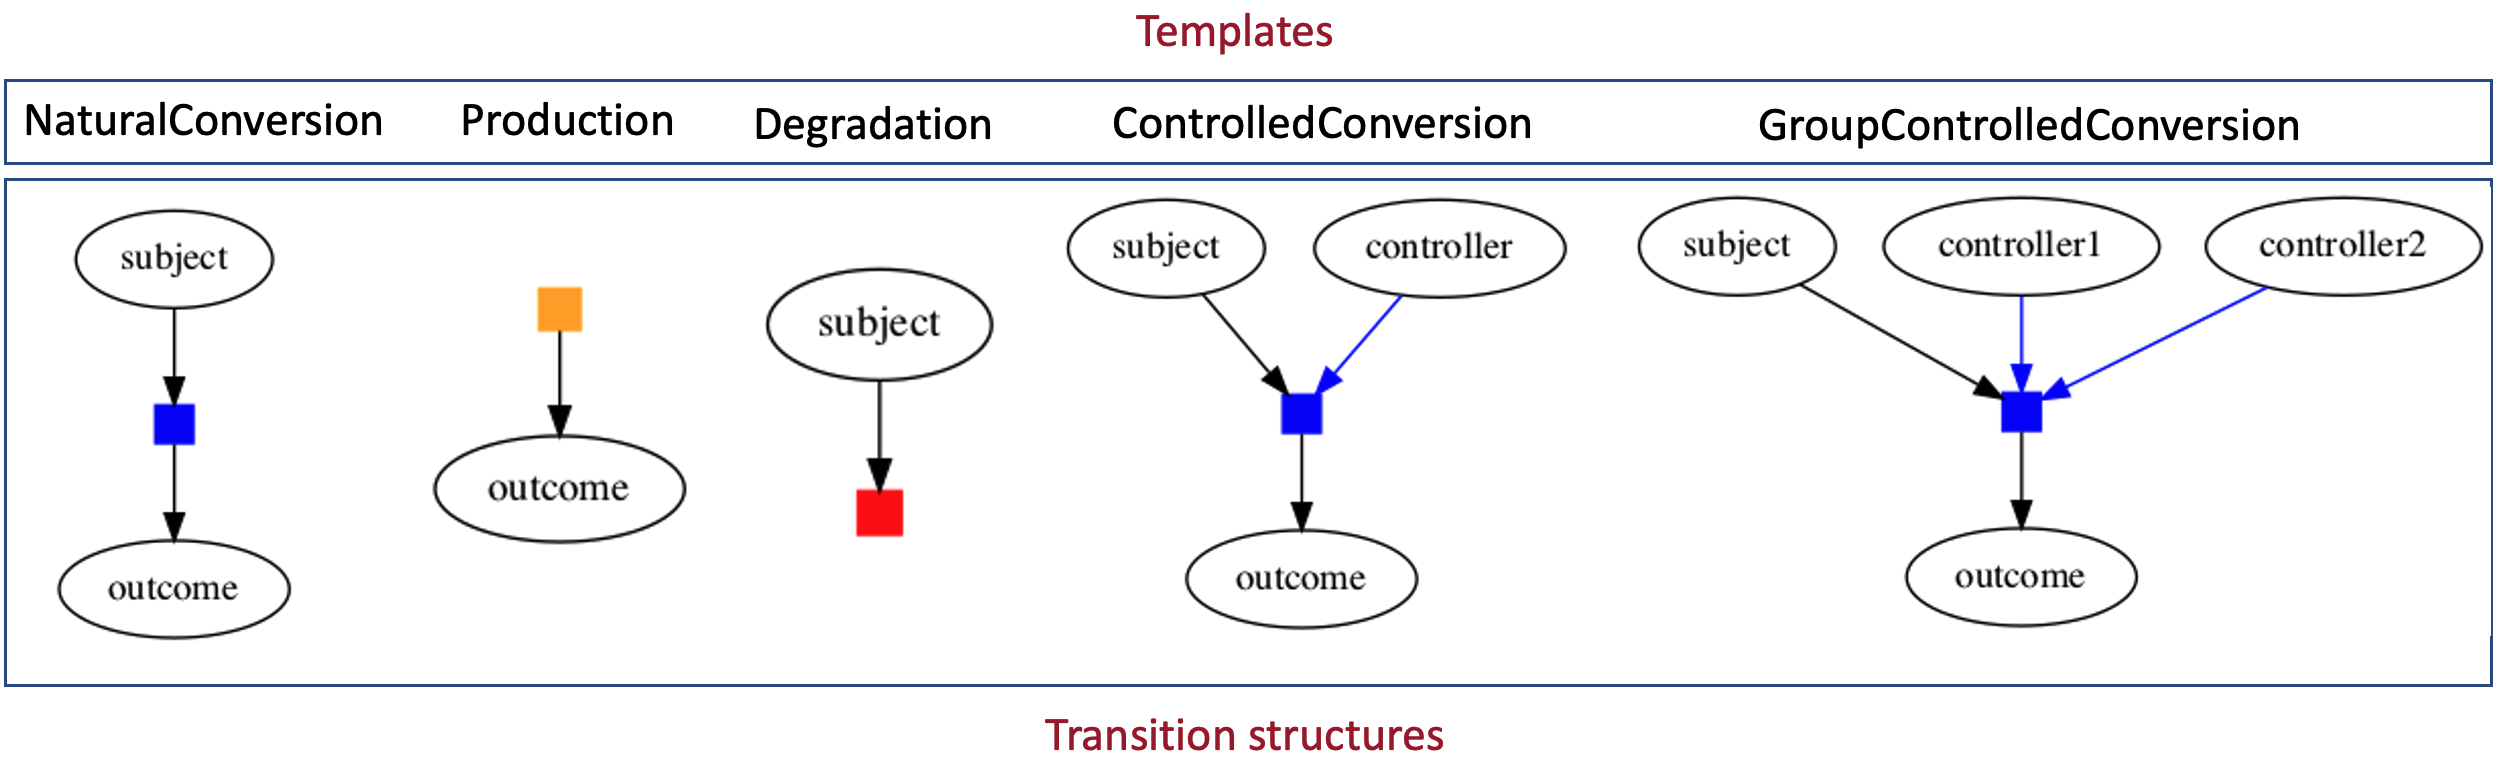

### Collection of 26 BioModels represented as MIRA template models
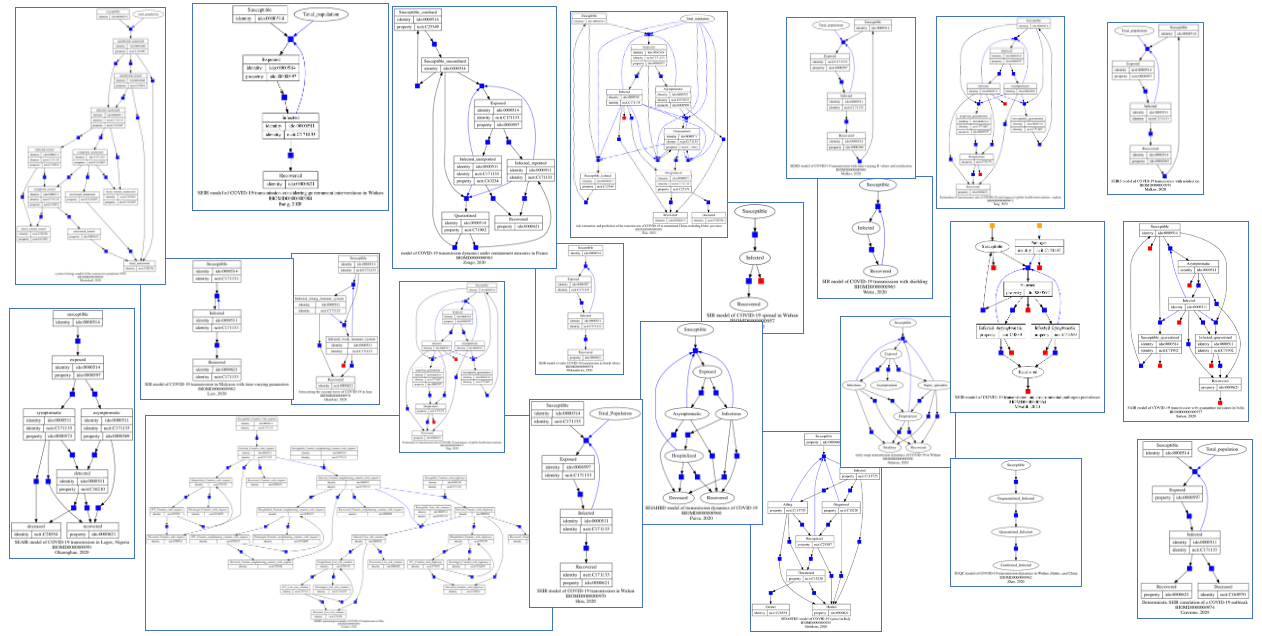

## Representing rate laws and parameters

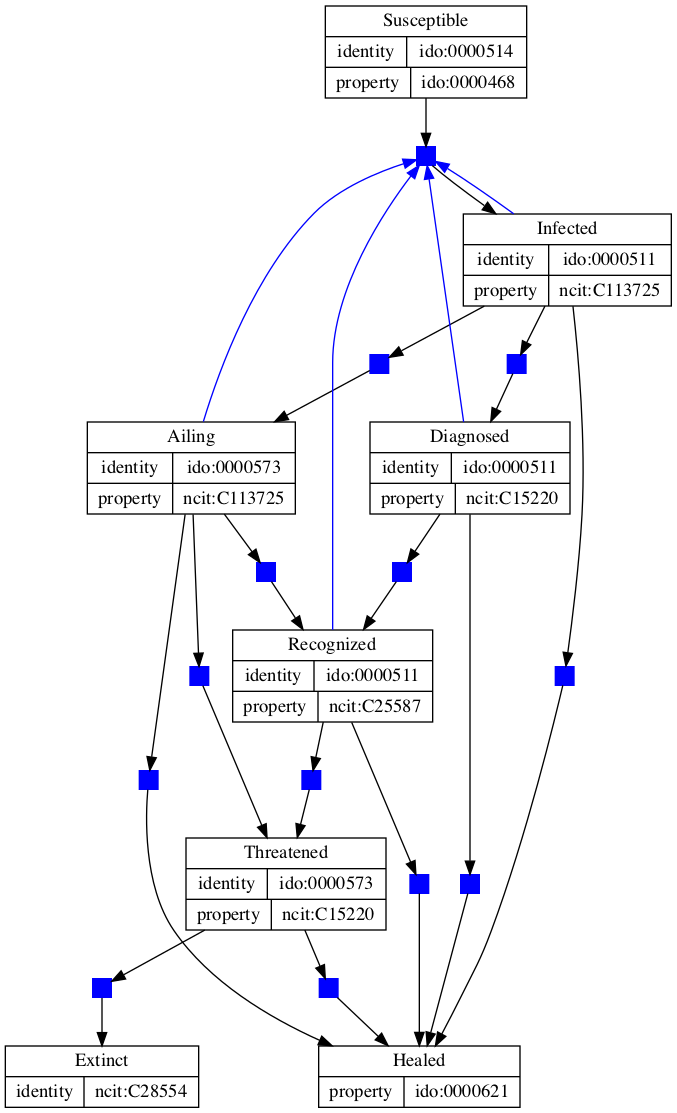

In [4]:
from IPython.display import Image, display, HTML
from mira.modeling import Model
from mira.modeling.viz import GraphicalModel

template_model = get_template_model('BIOMD0000000955')
GraphicalModel(Model(template_model)).write('model.png')
Image('model.png', width='50%')

Let's now look at some rate laws from the model and list the corresponding parameters.

In [5]:
for template in template_model.templates:
    print(template.rate_law)

Italy*Susceptible*(Ailing*gamma + Diagnosed*beta + Infected*alpha + Recognized*delta)
Infected*Italy*epsilon
Infected*Italy*zeta
Infected*Italy*XXlambdaXX
Diagnosed*Italy*eta
Diagnosed*Italy*rho
Ailing*Italy*theta
Ailing*Italy*kappa
Ailing*Italy*mu
Italy*Recognized*nu
Italy*Recognized*xi
Italy*Threatened*tau
Italy*Threatened*sigma


In [6]:
list(template_model.parameters.items())[:15]

[('alpha', 0.57),
 ('beta', 0.011),
 ('gamma', 0.456),
 ('delta', 0.011),
 ('epsilon', 0.171),
 ('theta', 0.371),
 ('zeta', 0.125),
 ('eta', 0.125),
 ('mu', 0.017),
 ('nu', 0.027),
 ('tau', 0.01),
 ('kappa', 0.017),
 ('rho', 0.034),
 ('sigma', 0.017),
 ('xi', 0.017)]

## Comparing models at the template level with ontology guidance
We get a set of BioModels models as examples for interesting comparisons.

In [7]:
models = {
    mid: get_template_model(f'BIOMD0000000{mid}')
    for mid in ['957', '963', '970', '984', '991']
}

In [8]:
viz = {'970', '991'}
for mid in viz:
    gm = GraphicalModel(Model(models[mid]))
    gm.write(f'{mid}.png', args=f'-Glabel=BIOMD0000000{mid}')
HTML('<div class="row">' + '\n'.join([f'<img src={mid}.png style="width:40%;float:left"> </img>'
                                      for mid in viz]) + '</div>')

Let's now get our model comparison code ready and use MIRA's template model comparison algorithm to create a model comparison graph. We can also visualize this graph.

The comparison algorithm uses the MIRA DKG's structure.

In [9]:
from mira.metamodel import TemplateModelDelta, get_dkg_refinement_closure
from mira.dkg.web_client import is_ontological_child_web
refinement_fun = get_dkg_refinement_closure().is_ontological_child

INFO: [2022-10-13 00:01:42] mira.dkg.client - Finding related nodes according to subclassof|part_of...
INFO: [2022-10-13 00:01:58] mira.dkg.client - Building transitive closure...


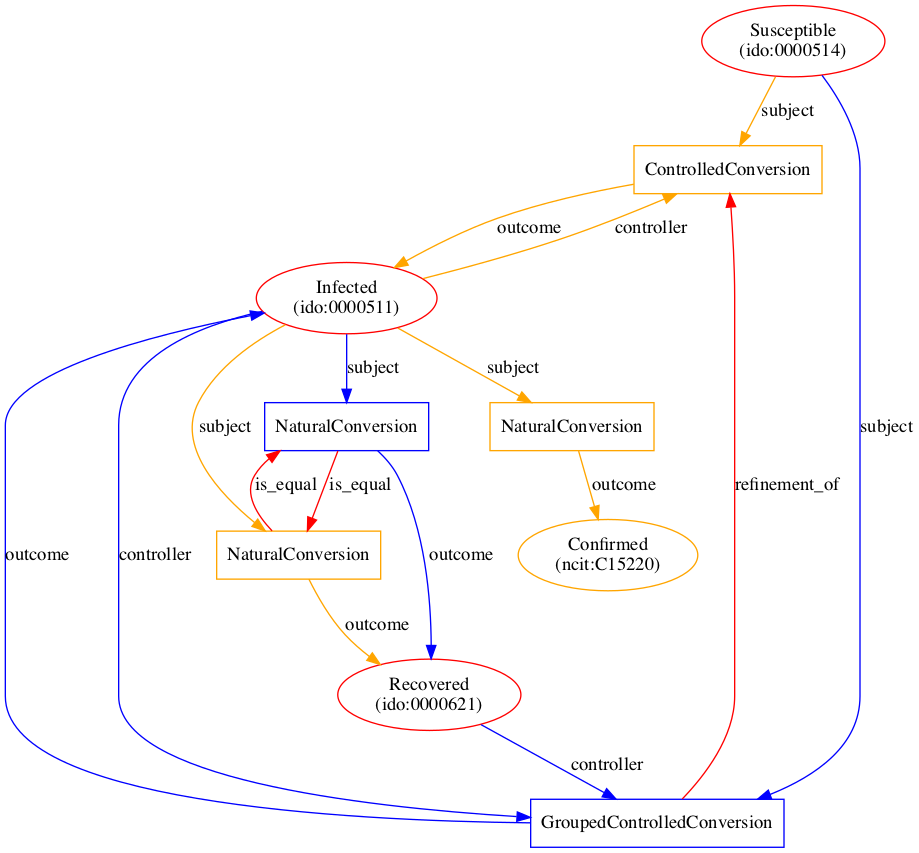

In [10]:
td = TemplateModelDelta(models['957'], models['963'], refinement_fun)
td.draw_graph('comparison3.png', args='-Grankdir=TB')
Image('comparison3.png')

Next we compare two models where there are interesting node-level refinements.

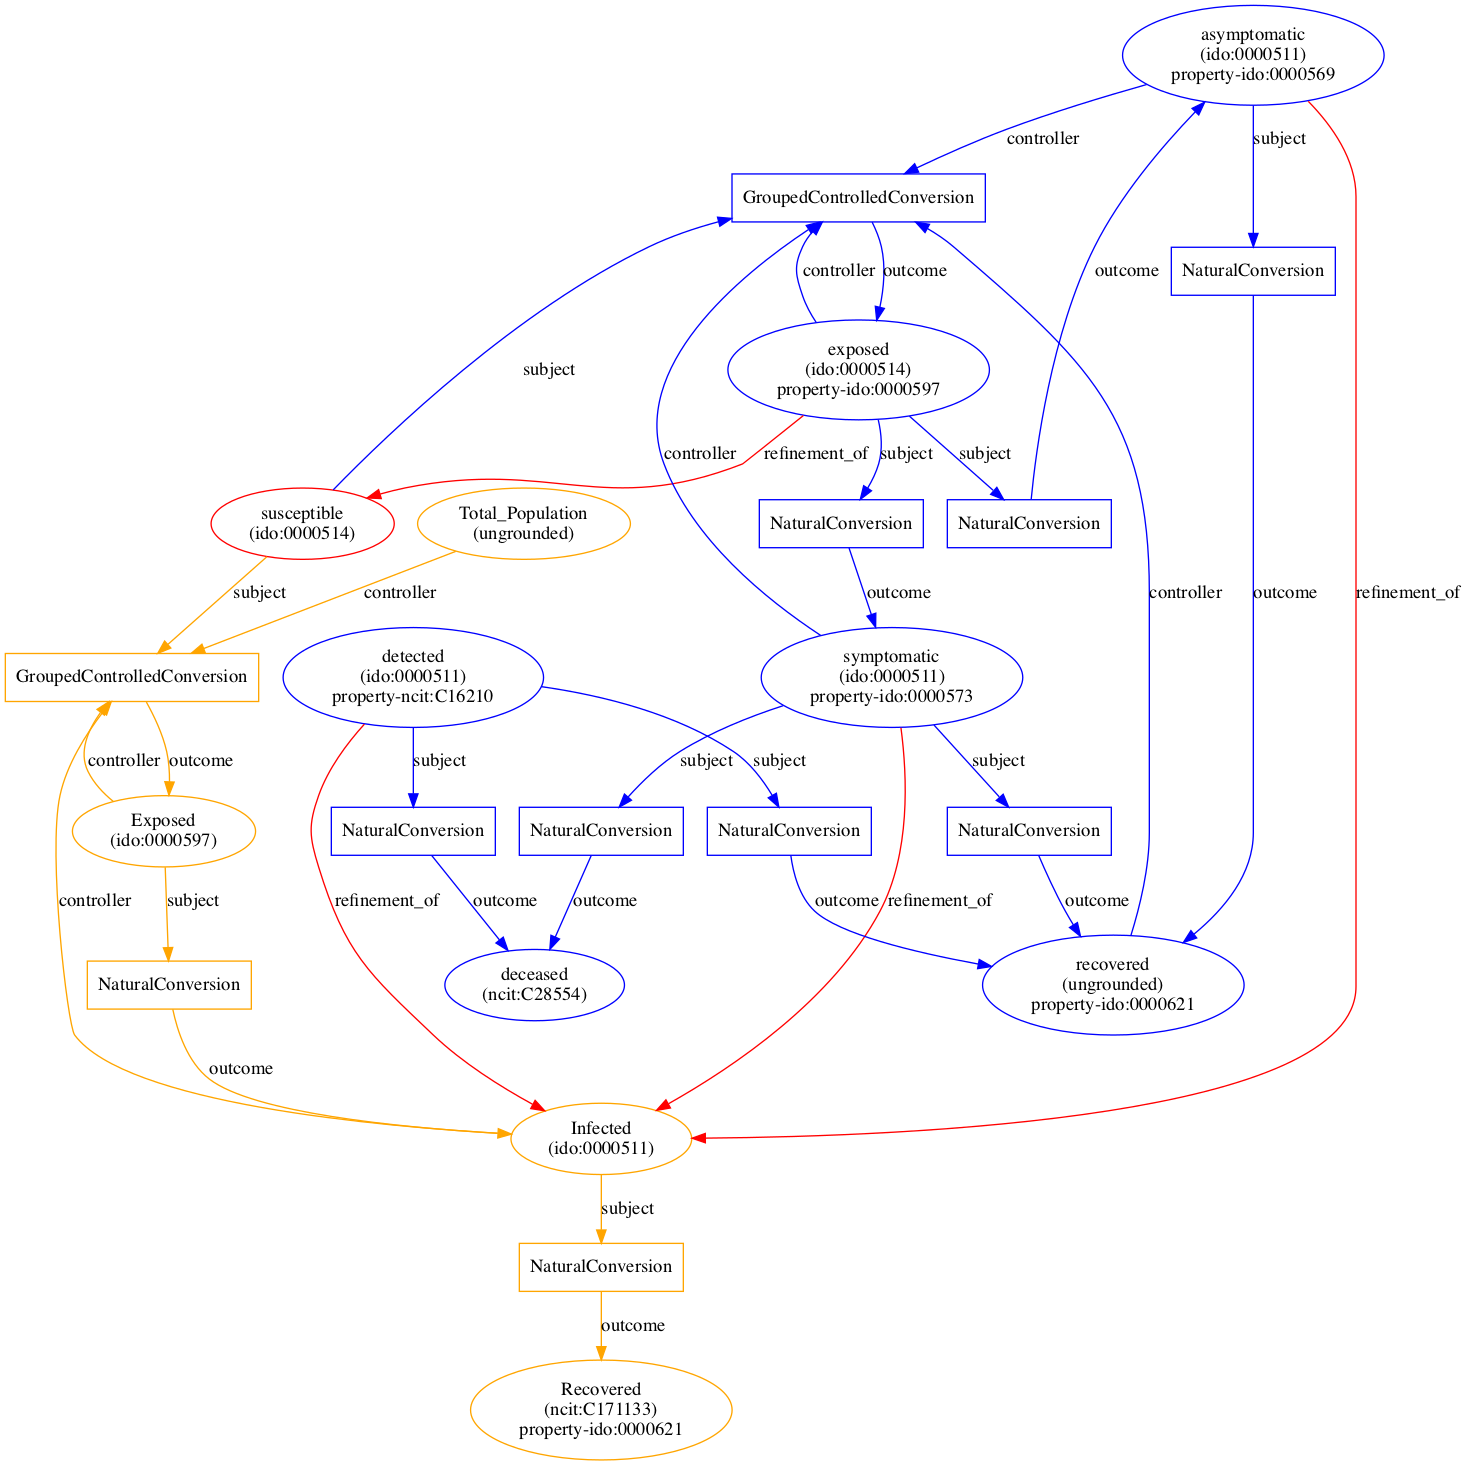

In [11]:
td = TemplateModelDelta(models['970'], models['991'], refinement_fun)
td.draw_graph('comparison1.png', args='-Grankdir=TB')
Image('comparison1.png')

In this example, we see that there are template-level relationships between two NaturalConversions in the two models.

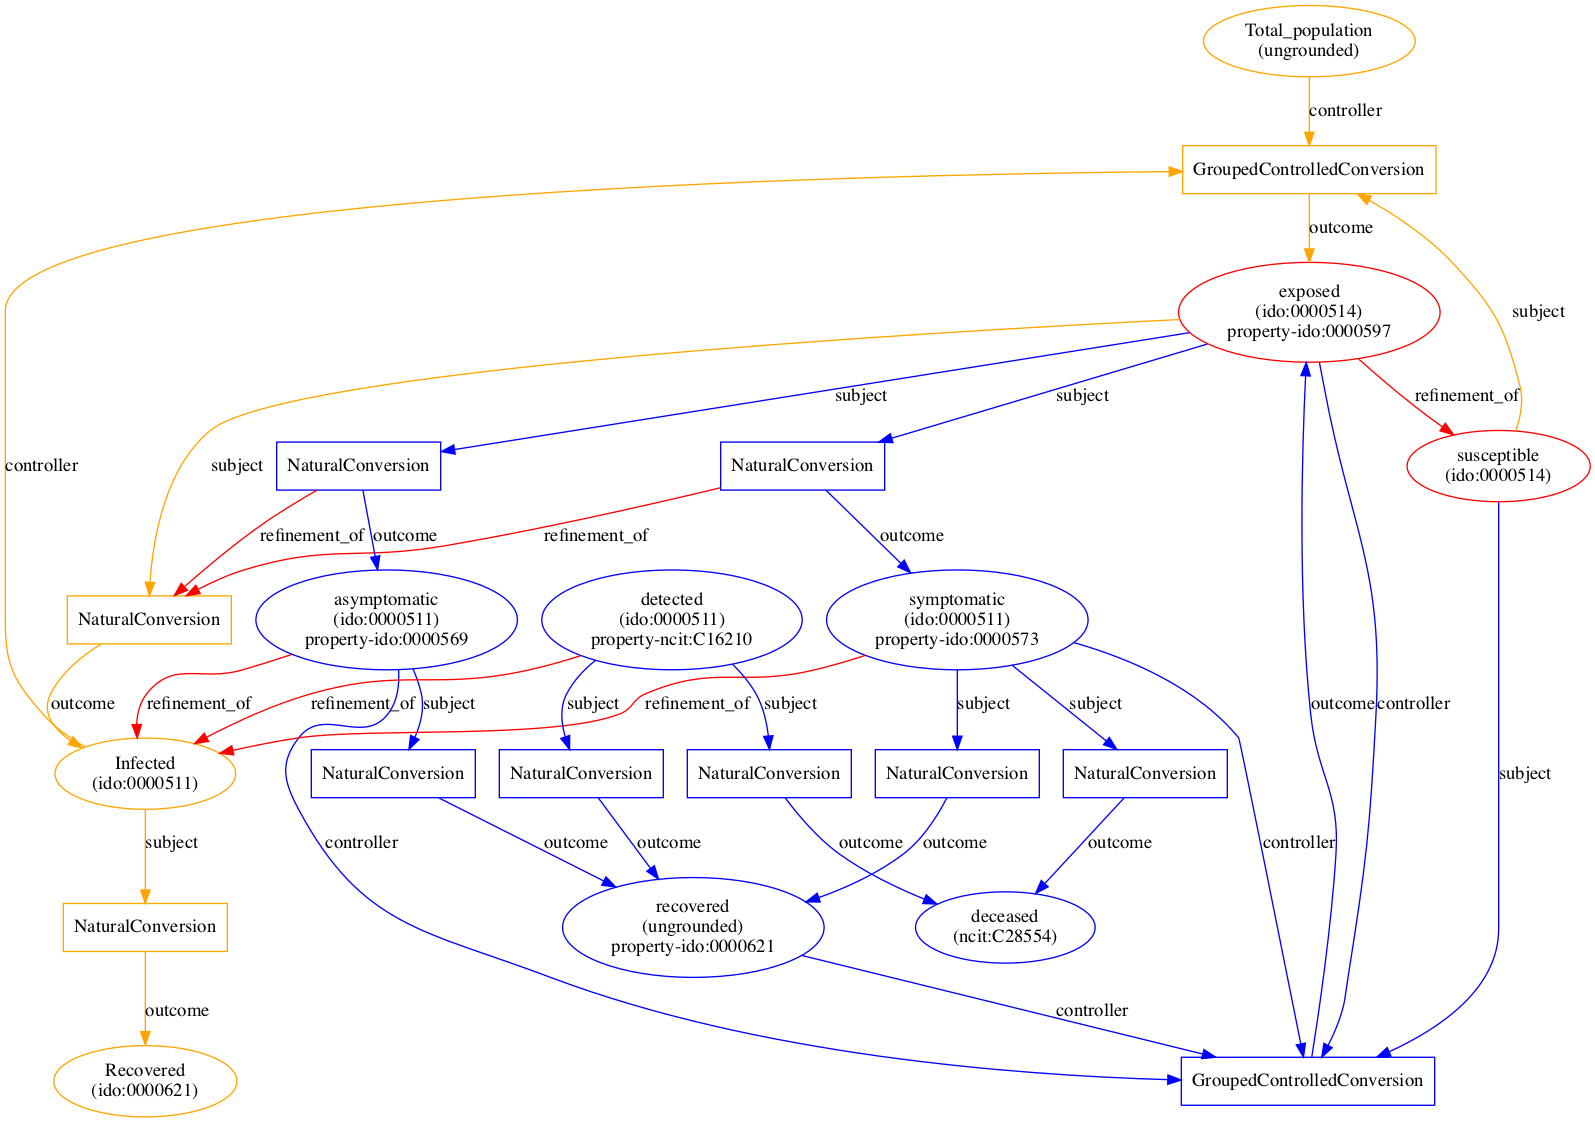

In [12]:
td = TemplateModelDelta(models['984'], models['991'], refinement_fun)
td.draw_graph('comparison2.png', args='-Grankdir=TB')
Image('comparison2.png')

## Generating model exchange formats from MIRA
Currently surpported
- Petri nets: https://miramodel.readthedocs.io/en/latest/modeling.html#module-mira.modeling.acsets.petri
- Bilayers: https://miramodel.readthedocs.io/en/latest/modeling.html#module-mira.modeling.bilayer
- ODEs: https://miramodel.readthedocs.io/en/latest/modeling.html#module-mira.modeling.ode

In [13]:
from mira.modeling.acsets.petri import PetriNetModel
pm = PetriNetModel(Model(models['991']))
pm.to_json()

{'S': [{'sname': 'susceptible',
   'mira_ids': "[('identity', 'ido:0000514')]",
   'mira_context': '[]'},
  {'sname': 'exposed',
   'mira_ids': "[('identity', 'ido:0000514')]",
   'mira_context': "[('property', 'ido:0000597')]"},
  {'sname': 'asymptomatic',
   'mira_ids': "[('identity', 'ido:0000511'), ('identity', 'ncit:C171133')]",
   'mira_context': "[('property', 'ido:0000569')]"},
  {'sname': 'recovered',
   'mira_ids': '[]',
   'mira_context': "[('property', 'ido:0000621')]"},
  {'sname': 'symptomatic',
   'mira_ids': "[('identity', 'ido:0000511'), ('identity', 'ncit:C171133')]",
   'mira_context': "[('property', 'ido:0000573')]"},
  {'sname': 'detected',
   'mira_ids': "[('identity', 'ido:0000511')]",
   'mira_context': "[('property', 'ncit:C16210')]"},
  {'sname': 'deceased',
   'mira_ids': "[('identity', 'ncit:C28554')]",
   'mira_context': '[]'}],
 'T': [{'tname': "(('susceptible', ('identity', 'ido:0000514')), ('exposed', ('identity', 'ido:0000514'), ('property', 'ido:000059

## Deployment and integration
MIRA is available at: https://github.com/indralab/mira, and can be used as
- A Python library, documented at https://miramodel.readthedocs.io/
- A local, dockerized REST API: https://github.com/indralab/mira/tree/main/docker#readme
- A public REST API: http://mira-epi-dkg-lb-dc1e19b273dedaa2.elb.us-east-1.amazonaws.com/

In [14]:
%%html
<iframe src="http://mira-epi-dkg-lb-dc1e19b273dedaa2.elb.us-east-1.amazonaws.com/docs" width="1000" height="1000"></iframe>